### Блок 1: First cell (imports and dataset loading)


In [10]:
import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader


# Load the dataset
ds = load_dataset("Aniemore/resd_annotated")

# Convert to pandas DataFrame for easier manipulation
train_df = pd.DataFrame(ds['train'])
test_df = pd.DataFrame(ds['test'])

# Print some information about the dataset
print("Training set size:", len(train_df))
print("Test set size:", len(test_df))
print("\nSample paths:")
print(train_df['path'].head())

# Create label encoder for emotions
label_encoder = LabelEncoder()
train_df['emotion_encoded'] = label_encoder.fit_transform(train_df['emotion'])
test_df['emotion_encoded'] = label_encoder.transform(test_df['emotion'])

# Print unique emotions and their counts
print("\nUnique emotions:", label_encoder.classes_)
print("\nEmotion distribution in training set:")
print(train_df['emotion'].value_counts())

Unique emotions: ['anger' 'disgust' 'enthusiasm' 'fear' 'happiness' 'neutral' 'sadness']

Emotion distribution in training set:
emotion
fear          178
anger         175
happiness     174
enthusiasm    158
neutral       153
disgust       148
sadness       130
Name: count, dtype: int64


### Блок 2: Dataset class


In [11]:
class AudioEmotionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Get the audio path and emotion
        audio_path = self.df.iloc[idx]['path']
        emotion = self.df.iloc[idx]['emotion_encoded']
        
        try:
            # Load audio file
            waveform, sample_rate = torchaudio.load(audio_path)
            
            # Convert to mono if stereo
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)
            
            # Apply transformations if any
            if self.transform:
                waveform = self.transform(waveform)
                
            return waveform, emotion
            
        except Exception as e:
            print(f"Error loading file {audio_path}: {str(e)}")
            # Return a zero tensor as fallback
            return torch.zeros((1, 16000)), emotion  # 1 second of silence at 16kHz

class AudioTransform:
    def __init__(self):
        self.resample = T.Resample(orig_freq=16000, new_freq=16000)
        self.mel_spectrogram = T.MelSpectrogram(
            sample_rate=16000,
            n_fft=1024,
            hop_length=512,
            n_mels=128
        )
        self.amplitude_to_db = T.AmplitudeToDB()
    
    def __call__(self, waveform):
        # Apply transforms sequentially
        waveform = self.resample(waveform)
        mel_spec = self.mel_spectrogram(waveform)
        mel_spec_db = self.amplitude_to_db(mel_spec)
        return mel_spec_db

# Create transform instance
audio_transform = AudioTransform()

# Create datasets
train_dataset = AudioEmotionDataset(train_df, transform=audio_transform)
test_dataset = AudioEmotionDataset(test_df, transform=audio_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Блок 3: Data preparation and augmentation

In [9]:
# # Define audio transformations
# audio_transform = T.Compose([
#     T.Resample(orig_freq=16000, new_freq=16000),  # Resample to 16kHz if needed
#     T.MelSpectrogram(
#         sample_rate=16000,
#         n_fft=1024,
#         hop_length=512,
#         n_mels=128
#     ),
#     T.AmplitudeToDB()
# ])

# # Create datasets
# train_dataset = AudioEmotionDataset(train_df, transform=audio_transform)
# test_dataset = AudioEmotionDataset(test_df, transform=audio_transform)

# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

AttributeError: module 'torchaudio.transforms' has no attribute 'Compose'

### Блок 4: Model definition


In [12]:
class EmotionRecognitionModel(nn.Module):
    def __init__(self, num_classes):
        super(EmotionRecognitionModel, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Initialize model
num_classes = len(label_encoder.classes_)
model = EmotionRecognitionModel(num_classes)

### Блок 5: Training loop


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)
        
    return total_loss / len(train_loader), 100. * correct / total

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%')

  0%|          | 0/35 [00:00<?, ?it/s]


LibsndfileError: Error opening 'sadness_enthusiasm_24/24_sadness_enthusiasm_e_140.wav': System error.

### Блок 6: Evaluation


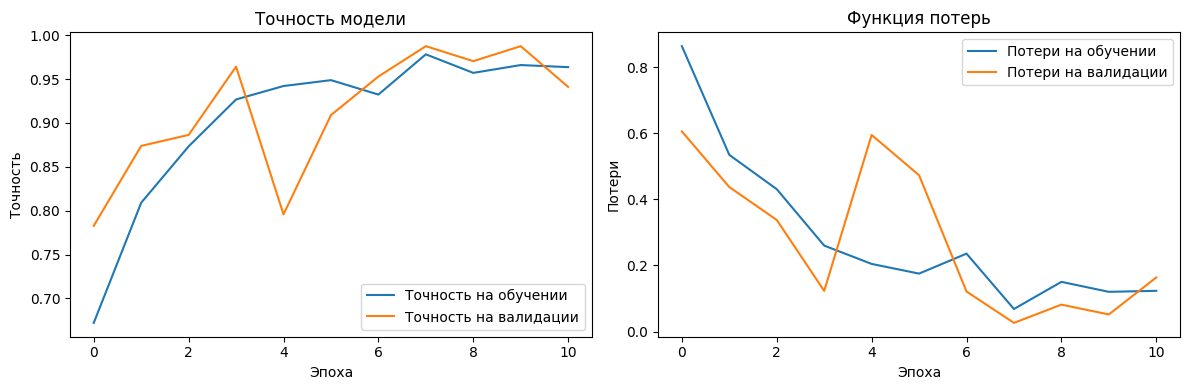

In [ ]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    
    return total_loss / len(test_loader), 100. * correct / total

test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

### Блок 7: Сохранение модели


In [15]:
# Сохранение модели
model.save('emotion_recognition_model.h5')
print("\nМодель сохранена как 'emotion_recognition_model.h5'")

# Сохранение label encoder
import joblib
joblib.dump(label_encoder, 'label_encoder.joblib')
print("LabelEncoder сохранен как 'label_encoder.joblib'")


Модель сохранена как 'emotion_recognition_model.h5'
LabelEncoder сохранен как 'label_encoder.joblib'


### Блок 8: Тестирование модели

Загрузка тестовых данных...
Загрузка аудио файлов и извлечение признаков...
Найдено 19927 валидных файлов
Размер тестовой выборки: 19927

Получение предсказаний...
623/623 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step

Оценка модели на тестовой выборке:
623/623 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9868 - loss: 0.0286
Тестовая точность: 0.9861
Тестовые потери: 0.0292

Отчет о классификации:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       784
         2.0       1.00      0.99      1.00      9534
         3.0       0.97      1.00      0.98      7887
         4.0       1.00      1.00      1.00      1351
         5.0       1.00      0.48      0.65       371

    accuracy                           0.99     19927
   macro avg       0.99      0.89      0.93     19927
weighted avg       0.99      0.99      0.98     19927



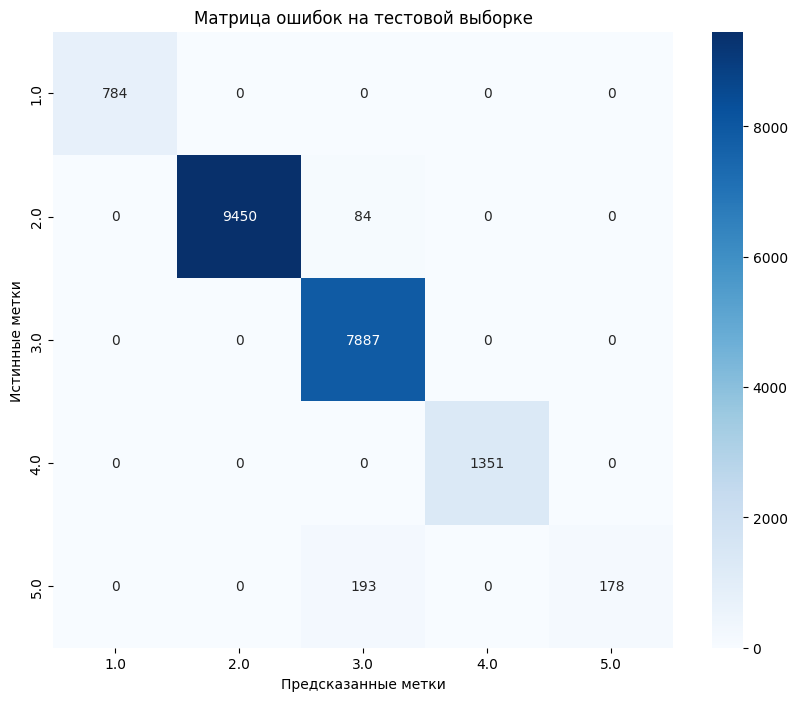


Результаты сохранены в 'test_results.csv'


In [ ]:
# Загрузка тестовых данных
print("Загрузка тестовых данных...")
test_df = pd.read_csv('podcast/podcast_train/cleaned_podcast_train.tsv', sep='\t')

# Загрузка тестовых данных
print("Загрузка аудио файлов и извлечение признаков...")
X_test = []
y_test = []
valid_files = []

for index, row in test_df.iterrows():
    try:
        audio_path = os.path.join('podcast/podcast_train', row['audio_path'])
        if os.path.exists(audio_path):
            mfcc = load_audio(audio_path)
            if mfcc.shape[0] > 1:
                X_test.append(mfcc)
                y_test.append(row['golden_emo'])
                valid_files.append(row['audio_path'])
    except Exception as e:
        print(f"Ошибка при загрузке {audio_path}: {e}")
        continue

if len(X_test) == 0:
    print("Не найдено валидных тестовых файлов!")
else:
    print(f"Найдено {len(X_test)} валидных файлов")

    # Приведение всех MFCC к одной длине
    max_length = max([mfcc.shape[0] for mfcc in X_test])
    X_test_padded = np.array([np.pad(mfcc, ((0, max_length - mfcc.shape[0]), (0, 0)), mode='constant') for mfcc in X_test])

    # Преобразование меток
    y_test = np.array(y_test)
    y_test_encoded = label_encoder.transform(y_test)

    print(f"Размер тестовой выборки: {len(X_test)}")

    # Получение предсказаний
    print("\nПолучение предсказаний...")
    y_pred = model.predict(X_test_padded)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Оценка модели
    print("\nОценка модели на тестовой выборке:")
    test_loss, test_accuracy = model.evaluate(X_test_padded, y_test_encoded)
    print(f"Тестовая точность: {test_accuracy:.4f}")
    print(f"Тестовые потери: {test_loss:.4f}")

    # Вывод отчета о классификации
    print("\nОтчет о классификации:")
    target_names = [str(cls) for cls in label_encoder.classes_]
    print(classification_report(y_test_encoded, y_pred_classes, target_names=target_names))

    # Построение матрицы ошибок
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test_encoded, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.title('Матрица ошибок на тестовой выборке')
    plt.xlabel('Предсказанные метки')
    plt.ylabel('Истинные метки')
    plt.show()

    # Сохранение результатов
    results_df = pd.DataFrame({
        'audio_path': valid_files,
        'true_label': y_test,
        'predicted_label': label_encoder.inverse_transform(y_pred_classes)
    })
    results_df.to_csv('test_results.csv', index=False)
    print("\nРезультаты сохранены в 'test_results.csv'")
